In [24]:
# PyTorch Image Classification Model for Bug Bite Detection
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import glob
from dotenv import load_dotenv
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load environment variables
load_dotenv()

# Get training and test folders from environment
TRAIN_FOLDER = os.getenv('TRAIN_FOLDER', 'images/run20250806_203706')
TEST_FOLDER = os.getenv('TEST_FOLDER', 'test_images')

print(f"Training folder: {TRAIN_FOLDER}")
print(f"Test folder: {TEST_FOLDER}")

# Check if folders exist
train_path = os.path.join(os.getcwd(), TRAIN_FOLDER)
test_path = os.path.join(os.getcwd(), TEST_FOLDER)

print(f"Full train path: {train_path}")
print(f"Full test path: {test_path}")
print(f"Train folder exists: {os.path.exists(train_path)}")
print(f"Test folder exists: {os.path.exists(test_path)}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Training folder: images/run20250806_203706
Test folder: test_images
Full train path: /Users/chrisbuonocore/personal/python/dermaclassify/images/run20250806_203706
Full test path: /Users/chrisbuonocore/personal/python/dermaclassify/test_images
Train folder exists: True
Test folder exists: True
Using device: cpu


In [25]:
# Custom Dataset Class for Bug Bite Images
class BugBiteDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = []

        # Find all image files and extract labels from filenames
        image_files = glob.glob(os.path.join(folder_path, "*.jpg")) + \
                     glob.glob(os.path.join(folder_path, "*.jpeg")) + \
                     glob.glob(os.path.join(folder_path, "*.png"))

        # Extract unique class names from filenames
        class_set = set()
        for img_path in image_files:
            filename = os.path.basename(img_path)
            # Extract class name (everything before the first underscore)
            if '_' in filename:
                class_name = filename.split('_')[0]
                class_set.add(class_name)

        self.class_names = sorted(list(class_set))
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.class_names)}

        print(f"Found classes: {self.class_names}")
        print(f"Class to index mapping: {self.class_to_idx}")

        # Process all images
        for img_path in image_files:
            filename = os.path.basename(img_path)
            if '_' in filename:
                class_name = filename.split('_')[0]
                if class_name in self.class_to_idx:
                    self.images.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])

        print(f"Loaded {len(self.images)} images from {len(self.class_names)} classes")

        # Print class distribution
        label_counts = {}
        for label in self.labels:
            class_name = self.class_names[label]
            label_counts[class_name] = label_counts.get(class_name, 0) + 1

        print("Class distribution:")
        for class_name, count in label_counts.items():
            print(f"  {class_name}: {count} images")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image as fallback
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

# Enhanced transforms for better data augmentation and generalization
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
print("Creating training dataset...")
train_dataset = BugBiteDataset(train_path, transform=train_transform)

print(f"\nNumber of classes: {len(train_dataset.class_names)}")
print(f"Class names: {train_dataset.class_names}")

Creating training dataset...
Found classes: ['ANT', 'BED', 'FLEA', 'MOSQUITO', 'SPIDER']
Class to index mapping: {'ANT': 0, 'BED': 1, 'FLEA': 2, 'MOSQUITO': 3, 'SPIDER': 4}
Loaded 48 images from 5 classes
Class distribution:
  MOSQUITO: 20 images
  BED: 13 images
  FLEA: 9 images
  ANT: 3 images
  SPIDER: 3 images

Number of classes: 5
Class names: ['ANT', 'BED', 'FLEA', 'MOSQUITO', 'SPIDER']


In [26]:
# Enhanced CNN Model for Bug Bite Classification with Transfer Learning
import torchvision.models as models

class BugBiteCNN(nn.Module):
    def __init__(self, num_classes, use_pretrained=True):
        super(BugBiteCNN, self).__init__()

        # Use ResNet18 as backbone for better feature extraction
        print(f"Creating model with transfer learning: {use_pretrained}")
        self.backbone = models.resnet18(pretrained=use_pretrained)

        # Replace the final layer with enhanced classifier
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# Create enhanced model with transfer learning
num_classes = len(train_dataset.class_names)
model = BugBiteCNN(num_classes, use_pretrained=True).to(device)

print(f"Enhanced model created with {num_classes} output classes")
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Using transfer learning with pre-trained ResNet18 backbone")

# Display model architecture
print("\nEnhanced Model Architecture:")
print(model)

Creating model with transfer learning: True
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/chrisbuonocore/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/Users/chrisbuonocore/personal/python/dermaclassify/env/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/chrisbuonocore/personal/python/dermaclassify/env/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100.0%
100.0%


Enhanced model created with 5 output classes
Model parameters: 11,573,317
Using transfer learning with pre-trained ResNet18 backbone

Enhanced Model Architecture:
BugBiteCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
      

In [27]:
# Enhanced Training Configuration (Optimized for faster training)
batch_size = 16  # Increased batch size for faster training
learning_rate = 0.0002  # Slightly higher learning rate to converge faster
num_epochs = 20  # Reduced from 40 to 20 for faster training

# Create data loaders
from sklearn.model_selection import train_test_split

# Split training data into train and validation
train_indices = list(range(len(train_dataset)))
train_idx, val_idx = train_test_split(train_indices, test_size=0.2, random_state=42,
                                      stratify=train_dataset.labels)

# Create subset datasets
train_subset = torch.utils.data.Subset(train_dataset, train_idx)
val_subset = torch.utils.data.Subset(train_dataset, val_idx)

# Create data loaders (num_workers=0 for Jupyter notebook compatibility)
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Batch size: {batch_size}")

# Enhanced loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing for better generalization
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3)  # AdamW with weight decay

# More sophisticated learning rate scheduling
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=learning_rate * 10,
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,  # Warmup for 30% of training
    anneal_strategy='cos'
)

print(f"Enhanced loss function: {criterion}")
print(f"Enhanced optimizer: {optimizer}")
print(f"Enhanced learning rate scheduler: OneCycleLR with cosine annealing")

Training samples: 38
Validation samples: 10
Batch size: 16
Enhanced loss function: CrossEntropyLoss()
Enhanced optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    base_momentum: 0.85
    betas: (0.95, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 8e-05
    lr: 7.999999999999999e-05
    max_lr: 0.002
    max_momentum: 0.95
    maximize: False
    min_lr: 8e-09
    weight_decay: 0.001
)
Enhanced learning rate scheduler: OneCycleLR with cosine annealing


In [28]:
# Enhanced Training Loop with Better Monitoring
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    print("=== STARTING ENHANCED TRAINING ===")

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    learning_rates = []

    best_val_acc = 0.0
    patience = 5  # Reduced patience for faster training
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()  # Step per batch for OneCycleLR

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            if batch_idx % 3 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f'  Batch {batch_idx:2d}/{len(train_loader)}, Loss: {loss.item():.4f}, LR: {current_lr:.6f}')

        # Calculate training metrics
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate validation metrics
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Print epoch results
        print(f'RESULTS - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'        - Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')
        print(f'        - Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

        # Early stopping and best model saving (reduced patience for faster training)
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            patience_counter = 0
            print(f'        - ✅ New best validation accuracy!')
        else:
            patience_counter += 1
            if patience_counter >= 5:  # Reduced patience from 10 to 5
                print(f'        - ⏹️  Early stopping triggered (patience=5)')
                break

    print(f"\n=== ENHANCED TRAINING COMPLETED ===")
    print(f"Best validation accuracy achieved: {best_val_acc:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Check if trained model already exists
model_save_path = 'bug_bite_model.pth'

if os.path.exists(model_save_path):
    print(f"Found existing trained model: {model_save_path}")
    print("Loading pre-trained model...")

    # Load the saved model
    checkpoint = torch.load(model_save_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    print(f"✓ Model loaded successfully!")
    print(f"  Classes: {checkpoint['class_names']}")
    print(f"  Number of classes: {checkpoint['num_classes']}")

    # No training history when loading pre-trained model
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    print("\nSkipping training - using pre-trained model.")

else:
    print(f"No existing model found at {model_save_path}")
    print("Starting training from scratch...")

    # Train the model
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
    )

    print("\nTraining completed!")

    # Save the trained model
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_names': train_dataset.class_names,
        'num_classes': num_classes,
        'model_config': {
            'input_size': (3, 224, 224),
            'num_classes': num_classes
        }
    }, model_save_path)

    print(f"Model saved to: {model_save_path}")

No existing model found at bug_bite_model.pth
Starting training from scratch...
=== STARTING ENHANCED TRAINING ===

Epoch 1/20
--------------------------------------------------
  Batch  0/3, Loss: 1.7028, LR: 0.000096
  Batch  0/3, Loss: 1.7028, LR: 0.000096
RESULTS - Train Loss: 1.7775, Train Acc: 13.16%
        - Val Loss: 1.6359, Val Acc: 20.00%
        - Learning Rate: 0.000224
        - ✅ New best validation accuracy!

Epoch 2/20
--------------------------------------------------
RESULTS - Train Loss: 1.7775, Train Acc: 13.16%
        - Val Loss: 1.6359, Val Acc: 20.00%
        - Learning Rate: 0.000224
        - ✅ New best validation accuracy!

Epoch 2/20
--------------------------------------------------
  Batch  0/3, Loss: 1.7662, LR: 0.000331
  Batch  0/3, Loss: 1.7662, LR: 0.000331
RESULTS - Train Loss: 1.6249, Train Acc: 18.42%
        - Val Loss: 1.5685, Val Acc: 60.00%
        - Learning Rate: 0.000612
        - ✅ New best validation accuracy!

Epoch 3/20
----------------

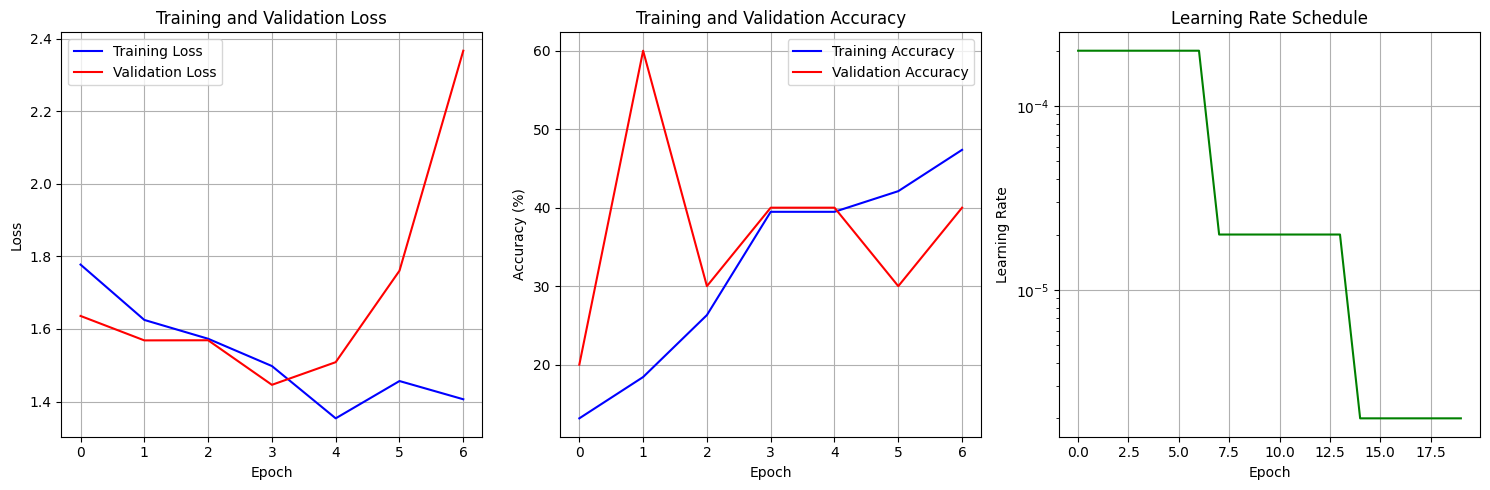


Final Training Results:
Final Training Accuracy: 47.37%
Final Validation Accuracy: 40.00%
Best Validation Accuracy: 60.00%

Model ready for predictions!


In [29]:
# Plot training progress (or show placeholder for loaded model)
if len(train_losses) > 0:  # We actually trained the model
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='red')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # Plot learning rate
    plt.subplot(1, 3, 3)
    lrs = []
    for epoch in range(num_epochs):
        if epoch < 7:
            lrs.append(learning_rate)
        elif epoch < 14:
            lrs.append(learning_rate * 0.1)
        else:
            lrs.append(learning_rate * 0.01)

    plt.plot(lrs, color='green')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print final results
    print(f"\nFinal Training Results:")
    print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
    print(f"Best Validation Accuracy: {max(val_accuracies):.2f}%")
else:
    print("\nUsing pre-trained model - no training curves to display.")
    print("Model is ready for inference!")

print(f"\nModel ready for predictions!")


Making predictions on test images from: /Users/chrisbuonocore/personal/python/dermaclassify/test_images
Found 4 test images

Processing: test4.jpg
  Predicted class: MOSQUITO
  Confidence: 0.8320 (83.20%)
  Top 3 predictions:
    1. MOSQUITO: 0.8320 (83.20%)
    2. BED: 0.1250 (12.50%)
    3. FLEA: 0.0220 (2.20%)
----------------------------------------
Processing: test1.jpg
  Predicted class: MOSQUITO
  Confidence: 0.8670 (86.70%)
  Top 3 predictions:
    1. MOSQUITO: 0.8670 (86.70%)
    2. BED: 0.1252 (12.52%)
    3. ANT: 0.0041 (0.41%)
----------------------------------------
Processing: test3.jpg
  Predicted class: MOSQUITO
  Confidence: 0.9589 (95.89%)
  Top 3 predictions:
    1. MOSQUITO: 0.9589 (95.89%)
    2. BED: 0.0189 (1.89%)
    3. FLEA: 0.0101 (1.01%)
  Predicted class: MOSQUITO
  Confidence: 0.8670 (86.70%)
  Top 3 predictions:
    1. MOSQUITO: 0.8670 (86.70%)
    2. BED: 0.1252 (12.52%)
    3. ANT: 0.0041 (0.41%)
----------------------------------------
Processing: test

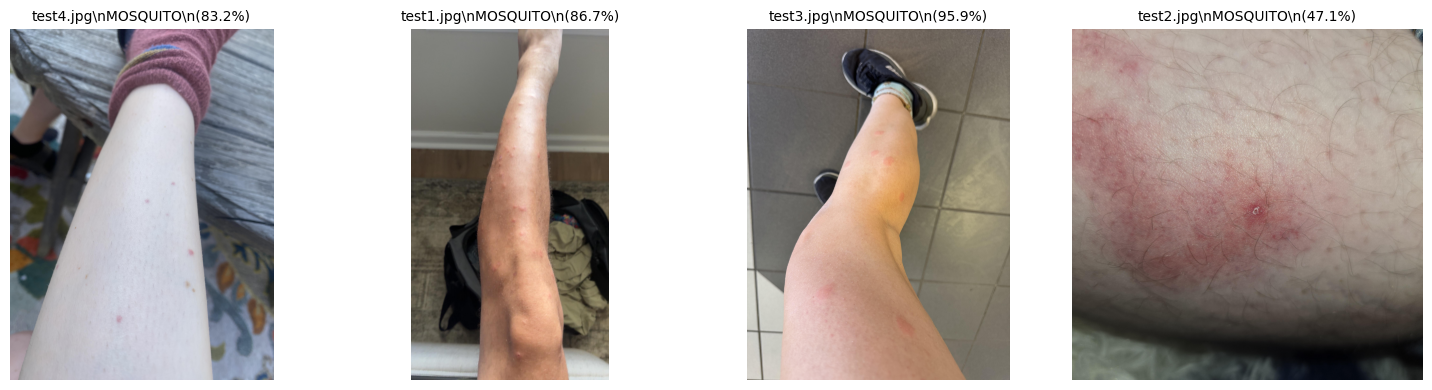

\nPREDICTION SUMMARY:
File: test4.jpg
  → MOSQUITO (confidence: 83.20%)
  Top 3: MOSQUITO (83.2%), BED (12.5%), FLEA (2.2%)

File: test1.jpg
  → MOSQUITO (confidence: 86.70%)
  Top 3: MOSQUITO (86.7%), BED (12.5%), ANT (0.4%)

File: test3.jpg
  → MOSQUITO (confidence: 95.89%)
  Top 3: MOSQUITO (95.9%), BED (1.9%), FLEA (1.0%)

File: test2.jpg
  → MOSQUITO (confidence: 47.14%)
  Top 3: MOSQUITO (47.1%), BED (39.3%), ANT (6.3%)

Total predictions made: 4


In [31]:
# Test Image Prediction Function
def predict_image(model, image_path, class_names, transform, device):
    """Predict the class of a single image"""
    model.eval()

    # Load and preprocess image
    try:
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)

        # Make prediction
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = F.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

        predicted_class = class_names[predicted.item()]
        confidence_score = confidence.item()

        # Get top 3 predictions
        top3_prob, top3_indices = torch.topk(probabilities, 3, dim=1)
        top3_classes = [(class_names[idx.item()], prob.item())
                       for idx, prob in zip(top3_indices[0], top3_prob[0])]

        return predicted_class, confidence_score, top3_classes, image

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None, None, None

# Test on all images in TEST_FOLDER
print(f"\nMaking predictions on test images from: {test_path}")
print("=" * 60)

test_image_files = glob.glob(os.path.join(test_path, "*.jpg")) + \
                   glob.glob(os.path.join(test_path, "*.jpeg")) + \
                   glob.glob(os.path.join(test_path, "*.png"))

if not test_image_files:
    print(f"No test images found in {test_path}")
else:
    print(f"Found {len(test_image_files)} test images\n")

    # Set up plotting for test results
    num_test_images = len(test_image_files)
    if num_test_images > 0:
        fig, axes = plt.subplots(1, min(num_test_images, 4), figsize=(15, 4))
        if num_test_images == 1:
            axes = [axes]
        elif num_test_images < 4:
            axes = axes[:num_test_images]

    predictions_summary = []

    for idx, image_path in enumerate(test_image_files):
        filename = os.path.basename(image_path)
        print(f"Processing: {filename}")

        predicted_class, confidence, top3_classes, image = predict_image(
            model, image_path, train_dataset.class_names, test_transform, device
        )

        if predicted_class is not None:
            print(f"  Predicted class: {predicted_class}")
            print(f"  Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
            print(f"  Top 3 predictions:")
            for i, (class_name, prob) in enumerate(top3_classes):
                print(f"    {i+1}. {class_name}: {prob:.4f} ({prob*100:.2f}%)")

            # Store prediction for summary
            predictions_summary.append({
                'filename': filename,
                'predicted_class': predicted_class,
                'confidence': confidence,
                'top3': top3_classes
            })

            # Plot image with prediction if we have space
            if idx < min(num_test_images, 4):
                if num_test_images > 1:
                    ax = axes[idx]
                else:
                    ax = axes[0]

                ax.imshow(image)
                ax.set_title(f'{filename}\\n{predicted_class}\\n({confidence*100:.1f}%)',
                           fontsize=10)
                ax.axis('off')

        print("-" * 40)

    if num_test_images > 0:
        plt.tight_layout()
        plt.show()

    # Print summary of all predictions
    print("\\nPREDICTION SUMMARY:")
    print("=" * 60)
    for pred in predictions_summary:
        print(f"File: {pred['filename']}")
        print(f"  → {pred['predicted_class']} (confidence: {pred['confidence']*100:.2f}%)")
        print(f"  Top 3: {', '.join([f'{cls} ({prob*100:.1f}%)' for cls, prob in pred['top3']])}")
        print()

    print(f"Total predictions made: {len(predictions_summary)}")